In [1]:
%reset
import numpy as np
import sys
from scipy.integrate import trapz, simps
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%run constants.ipynb

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
sys.path.append('../')
#sys.path.append('/home/anni/Work/Software/photosperic_code/working_version/photospheric_modeling')

In [3]:
from core import SimulationManager

In [4]:
def calculate_grid_parameters(xmin, xmax, ulim_lastbin):
    D_X = np.log(1/(1-ulim_lastbin/xmax))
    X_I = np.log(xmin)/D_X
    BIN_X = np.log(xmax)/D_X - X_I
    return D_X, int(X_I), int(BIN_X)

In [5]:
def calculate_grid_parameters_DX(xmin, xmax, D_X):
    X_I = np.log(xmin)/D_X
    BIN_X = np.log(xmax)/D_X - X_I
    return int(X_I), int(BIN_X)

In [6]:
delta_t = 5.e-11

In [7]:
D_X = 2.e-2
xmin = 1.e-9
xmax = 1.e1
X_I, BIN_X = calculate_grid_parameters_DX(xmin, xmax, D_X)
print(D_X, X_I, BIN_X)


0.02 -1036 1151


In [8]:
grid_parameters = {'BIN_X':BIN_X, 'D_X':D_X, 'X_I':X_I, 'type_grid' : 'log'}
solver_settings = {'include_kompaneets': True, 'kompaneets_extended_by': 'none', 'CN_solver': False }

In [9]:
sim = SimulationManager(grid_parameters, delta_t, solver_settings)

In [10]:
initial_array = np.zeros(BIN_X)

In [11]:
T = 10.e3/ k_B_eV

In [12]:
sim.source_parameters['T'] = T *k_B_erg/ m_e/c0**2
sim.source_parameters['n_e'] =6.e22
#sim.radius = 1.e-20
#sim.lorentz = 100
print(sim.source_parameters['T'])

0.01956951183606842


In [13]:
## this is the typical time between scatterings, timestep should be smaller ! 
print(1/(sim.source_parameters['n_e']*sigma_t*c0), sim.delta_t) 

8.356912549957172e-10 5e-11


In [14]:
energygrid = sim.energygrid

In [15]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [16]:
def gaussian(x, width, midpoint):
    res = 1/(width*np.sqrt(np.pi*2))*np.exp(-0.5*((x - midpoint)/width)**2)
    return res

In [17]:
idx = find_nearest(sim.energygrid, 500/(511.e3))
midpoint = idx
width = 3 # gridpoints, not energy
for i in range(BIN_X):
    initial_array[i] = 1.e3*gaussian(i, width, midpoint)


In [18]:
sim.initialise_run(initial_array)
modules = []
sim.reset_modules(modules)

In [19]:
arr_to_integrate = sim.energygrid**3*sim.photonarray
E_photons = 8* np.pi * (m_e*c0**2)**4/(c0*h)**3 *simps(arr_to_integrate, sim.energygrid)
print(E_photons)

arr_to_integrate = sim.energygrid**2*sim.photonarray
N_photons = 8* np.pi * (m_e*c0**2)**4/(c0*h)**3 *simps(arr_to_integrate, sim.energygrid)
sim.N = N_photons

28235260758796.934


In [20]:
E_ele = 3/2 * T *k_B_erg*sim.source_parameters['n_e']
print(E_ele)

1441958970624292.5


In [21]:
Etot = E_ele + E_photons

## Check the grid and the initial configurations

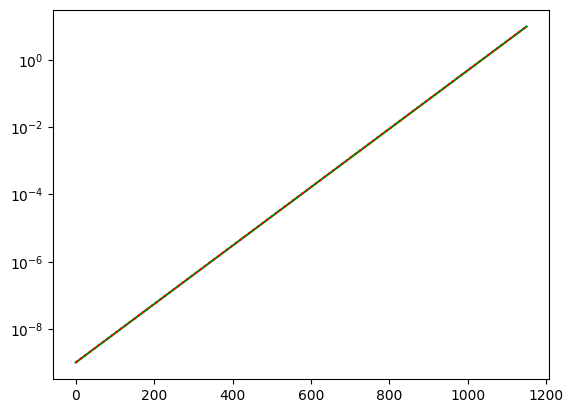

In [22]:
fig = plt.figure()

plt.plot(sim.energygrid, color = 'g')
plt.plot(sim.half_grid, ls = ':', color = 'r')


ax = plt.gca()
ax.set(yscale = 'log')
plt.show()

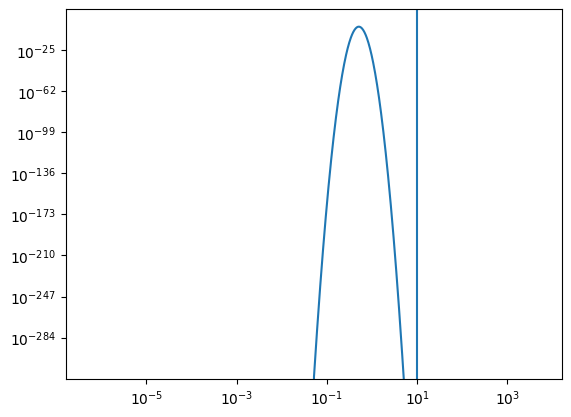

In [23]:
fig = plt.figure()

plt.plot(sim.energygrid*511, initial_array*sim.energygrid**2)
plt.axvline(sim.source_parameters['T']*511)
ax = plt.gca()
ax.set(yscale = 'log', xscale='log')
plt.show()

In [24]:
photon_temp_evolution = []
ele_temp_evolution = []
ele_temp_evolution_equi = []
ele_temp_evolution_calc = []
phot_temp_evolution_calc = []
dE_dt_evolution = []
Delta_E_ele_directly = []
delta_j_evolution = []

In [25]:
from scipy.interpolate import *

In [26]:
def calculate_t_ele_equilibrium(sim):
    denom = sim.E /(8* np.pi /(c0*h)**3*(m_e*c0**2)**4)
    array_to_integrate = sim.energygrid *sim.energygrid *sim.energygrid*sim.energygrid * sim.photonarray*(sim.photonarray +1)
    cspline = CubicSpline(sim.energygrid, array_to_integrate)
    nom = cspline.integrate(min(sim.energygrid), max(sim.energygrid))
    res = nom/(4*denom)
    return res

In [27]:
def calculate_t_ele(sim):
    array_to_integrate = sim.energygrid *sim.energygrid *sim.energygrid*sim.energygrid * sim.photonarray*(sim.photonarray +1)
    cspline = CubicSpline(sim.energygrid, array_to_integrate)
    nom = cspline.integrate(min(sim.energygrid), max(sim.energygrid))
    return nom
def calculate_t_phot(sim):
    denom = sim.E /(8* np.pi /(c0*h)**3*(m_e*c0**2)**4)
    return 4*denom

In [28]:
def calculate_dE_dt(sim):
    denom = sim.E /(8* np.pi /(c0*h)**3*(m_e*c0**2)**4)
    array_to_integrate = sim.energygrid *sim.energygrid *sim.energygrid*sim.energygrid * sim.photonarray*(sim.photonarray +1)
    cspline = CubicSpline(sim.energygrid, array_to_integrate)
    nom = cspline.integrate(min(sim.energygrid), max(sim.energygrid))
    res = sigma_t * sim.source_parameters['n_e'] *(8*np.pi*h)/(c0**2)*(m_e*c0**2)**4/h**4*(4 *sim.source_parameters['T']  * denom - nom )
    return res

In [29]:
sim.compute_E_total()
sim.compute_N_total()
E_photons_curr = sim.E
E_ele_curr = E_ele
for j in range(8):
    for k in range(500):
        dE_dt = calculate_dE_dt(sim)
        sim.clear_arrays_for_PDE
        sim.evolve_one_timestep()
        arr_to_integrate = sim.energygrid**3*sim.photonarray
        Delta_E_ele_directly.append(E_photons_curr - sim.E)
        E_ele_curr = E_photons_curr - sim.E
        E_photons_curr = sim.E
        T_e = E_ele_curr*2/3. /sim.source_parameters['n_e']
        ele_temp_evolution.append(T_e/m_e/c0**2)
        ele_temp_evolution_equi.append(calculate_t_ele_equilibrium(sim))
        ele_temp_evolution_calc.append(calculate_t_ele(sim))
        phot_temp_evolution_calc.append(calculate_t_phot(sim))
        dE_dt_evolution.append(dE_dt)
        #sim.T = T_e/m_e/c0**2
        sim.source_parameters['T'] -= dE_dt * sim.delta_t * 2/3 / sim.source_parameters['n_e']/m_e/c0**2
        print(k, sim.source_parameters['T'])
        clear_output(wait=True)
        photon_temp_evolution.append(sim.photonarray)
        delta_j_evolution.append(sim.delta_j)

499 0.009363944864090472


In [30]:
arr_to_integrate = sim.energygrid**3*sim.photonarray
E_photons = 8* np.pi * (m_e*c0**2)**4/(c0*h)**3 *trapz(arr_to_integrate, sim.energygrid)
print(E_photons)
E_ele = 3/2 * sim.source_parameters['T'] * k_B_erg*sim.source_parameters['n_e']
print(E_ele)


783934966573669.6
116354.8900139548


In [31]:
colors = sns.color_palette('BuPu', int(len(photon_temp_evolution)/1))
norm2 = matplotlib.colors.Normalize(vmin=0, vmax=sim.time/1)

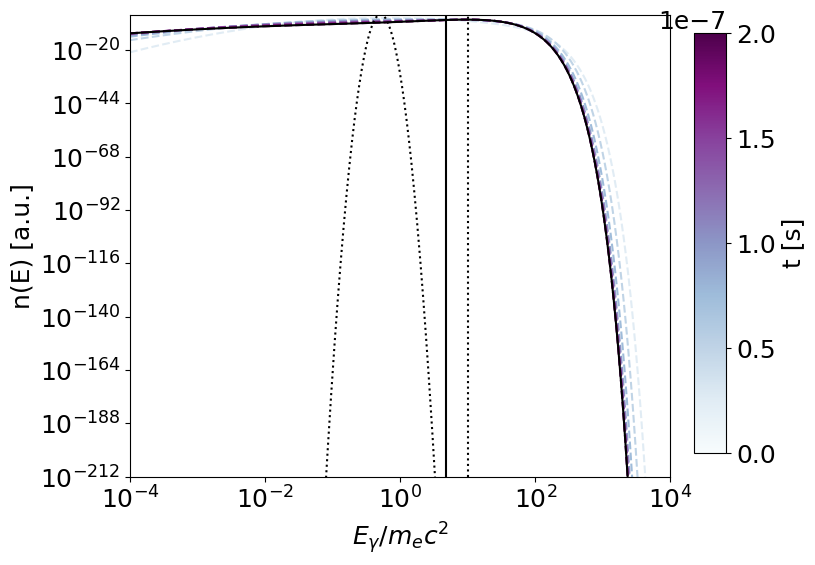

In [37]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

fig = plt.figure(figsize = [8, 6])


ax = plt.gca()

for j in range(8):
    k = j*500-1
    ax.plot(sim.energygrid*511, photon_temp_evolution[k]*sim.energygrid**2,
             ls = '--', c = colors[k])
    
ax.plot(sim.energygrid*511, sim.photonarray*sim.energygrid**2, color = 'k')
ax.plot(sim.energygrid*511, initial_array*sim.energygrid**2, ls = ':', 
         color = 'k')
ax.axvline(10., color = 'k', ls = ':')
ax.axvline(sim.source_parameters['T']*511, color = 'k', ls = '-')
ax.set(yscale = 'log', xscale = 'log', 
       xlim = [1.e-4, 1.e4], ylim = [1.e-212, 1.e-4],
      xlabel =r'$E_{\gamma}/ m_e c^2$',
      ylabel = 'n(E) [a.u.]')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.04, 0.7])
matplotlib.colorbar.ColorbarBase(cbar_ax, cmap='BuPu', norm = norm2, label = 't [s]')

plt.savefig('example_comptonisation.png', dpi = 300, bbox_inches = 'tight')
#ax.set(yscale = 'log', xscale = 'log', xlim = [1.e-12, 1.e3], ylim = [1.e-14, 1.e3])
plt.show()

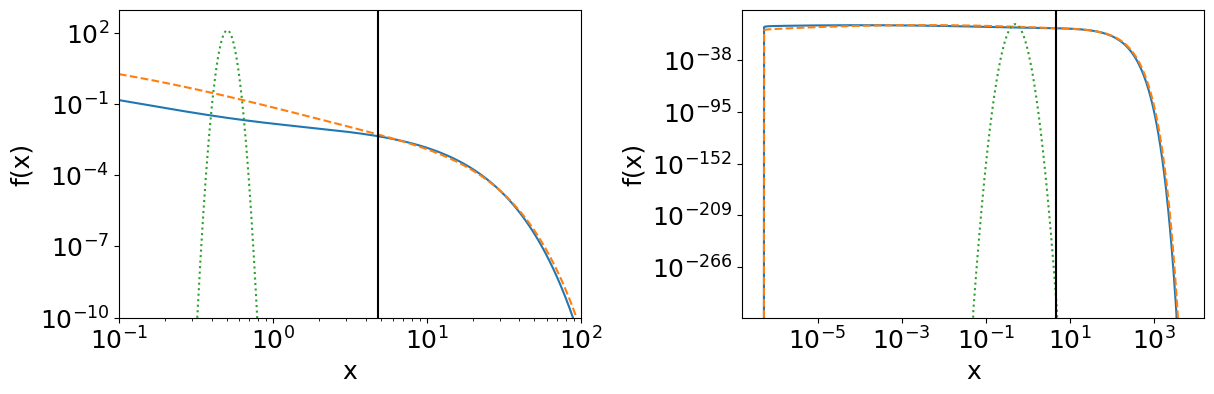

In [33]:
k_half = int(len(photon_temp_evolution)/2)
fig, axes = plt.subplots(1,2, figsize = [14, 4])
plt.subplots_adjust(wspace = 0.35)
ax = axes[0]
ax.plot(sim.energygrid*511, sim.photonarray)
ax.plot(sim.energygrid*511, photon_temp_evolution[k_half], ls = '--')

ax.plot(sim.energygrid*511, initial_array, ls = ':')
ax.axvline(sim.source_parameters['T'] *511, color = 'k')
ax.set(yscale = 'log', xscale = 'log', 
       xlim = [1.e-1, 1.e2], ylim = [1.e-10, 1.e3], 
        xlabel = 'x', ylabel = 'f(x)')


ax = axes[1]

ax.plot(sim.energygrid*511, sim.photonarray)
ax.plot(sim.energygrid*511, photon_temp_evolution[k_half], ls = '--')

ax.plot(sim.energygrid*511, initial_array, ls = ':')
ax.axvline(sim.source_parameters['T'] *511, color = 'k')
ax.set(yscale = 'log', xscale = 'log', xlabel = 'x', ylabel = 'f(x)')

#ax.set(yscale = 'log', xscale = 'log', xlim = [1.e-12, 1.e3], ylim = [1.e-14, 1.e3])
plt.show()

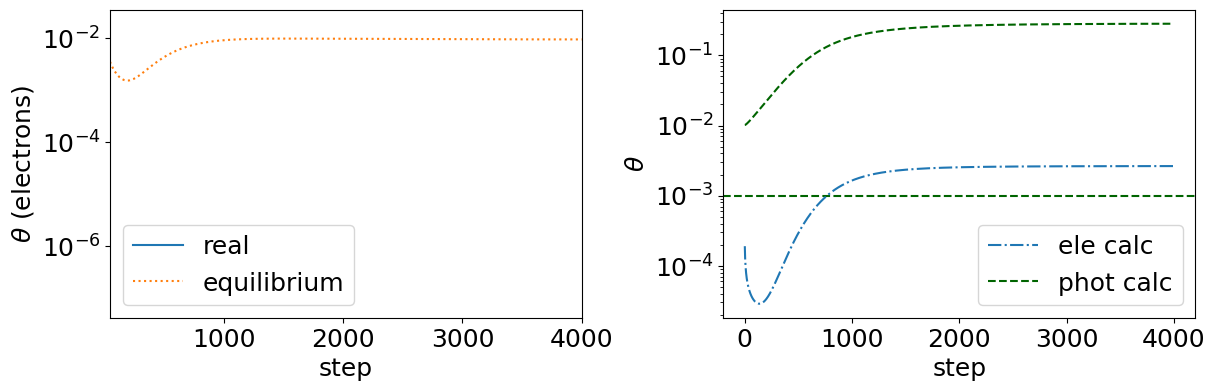

In [34]:
fig, axes = plt.subplots(1,2, figsize=[14, 4])
plt.subplots_adjust(wspace = 0.3)
ax = axes[0]
ax.plot(ele_temp_evolution, ls = '-', label = 'real')
ax.plot(ele_temp_evolution_equi, ls = ':', label = 'equilibrium')
ax.legend()

ax.set(yscale = 'log', ylabel = r'$\theta$ (electrons)', xlabel ='step', xlim = [50, 4000])
ax = axes[1]
ax.axhline(500/(511.e3), ls = '--', c = 'darkgreen')
ax.plot(np.asarray(ele_temp_evolution_calc)*129895610, ls = '-.', label = 'ele calc')
ax.plot(np.asarray(phot_temp_evolution_calc)*129895610, ls = '--', label = 'phot calc', c = 'darkgreen')
ax.set(yscale = 'log', ylabel = r'$\theta$', xlabel ='step')
ax.legend()

plt.show()

In [ ]:
%store -r delta_j_kompaneets
%store -r photon_temp_evolution_delta_j_kompaneets

In [ ]:
plt.plot(sim.half_grid, sim.heating_term)
plt.plot(sim.half_grid, sim.heating_term_kompaneets, ls = ':')
plt.plot(sim.half_grid, sim.dispersion_term)
plt.plot(sim.half_grid, sim.dispersion_term_kompaneets, ls = ':')
ax = plt.gca()
ax.set(yscale = 'log', xscale = 'log')

In [ ]:
print(np.log(1.e13))